In [467]:
import arrayworm as aw
import importlib as imp
imp.reload(aw)

<module 'arrayworm' from '/home/hornung/projects/pyworm/arrayworm.py'>

In [473]:
testlat = aw.Lattice(beta=1,s1=2,s2=2, ics=["s","s"])

In [474]:
testworm = aw.Worm(testlat)

In [475]:
print(testworm.wormtype)
print(testworm.ormtype)

testworm.wormtype

'u>s'

In [81]:
testlat.sites[(0,1)].find_event_in_dir(0.2, "BWD")
testlat.sites[(0,1)].add_event_at(0.2,{"FWD":1,"BWD":0},None,"tail")
testlat.sites[(0,1)].add_event_at(0.1,{"FWD":1,"BWD":0},None,"tail")
testlat.sites[(0,1)].add_event_at(0.5,{"FWD":1,"BWD":0},None,"tail")
testlat.sites[(0,1)].add_event_at(0.3,{"FWD":1,"BWD":0},None,"tail")
testlat.sites[(0,1)].delete_event_at(0.2)

testlat.sites[(0,1)].eventlist

[Event(time=0, spins={'FWD': 1, 'BWD': 1}, transitionto=None, kind='boundary'),
 Event(time=0.1, spins={'FWD': 1, 'BWD': 0}, transitionto=None, kind='tail'),
 Event(time=0.3, spins={'FWD': 1, 'BWD': 0}, transitionto=None, kind='tail'),
 Event(time=0.5, spins={'FWD': 1, 'BWD': 0}, transitionto=None, kind='tail'),
 Event(time=1, spins={'FWD': 1, 'BWD': 1}, transitionto=None, kind='boundary')]

In [83]:
testlat.sites[(0,1)].find_event_in_dir(0.1,"BWD")

Event(time=0, spins={'FWD': 1, 'BWD': 1}, transitionto=None, kind='boundary')

In [88]:
testlat.sites[(0,1)].find_event_at(0.1000000000000000000001)

Event(time=0.1, spins={'FWD': 1, 'BWD': 0}, transitionto=None, kind='tail')

In [116]:
for key,site in testlat.sites.items():
    print(key,site.eventlist)
    

(0, 1) [Event(time=0, spins={'FWD': 1, 'BWD': 1}, transitionto=None, kind='boundary'), Event(time=1, spins={'FWD': 1, 'BWD': 1}, transitionto=None, kind='boundary')]
(1, 0) [Event(time=0, spins={'FWD': 1, 'BWD': 1}, transitionto=None, kind='boundary'), Event(time=1, spins={'FWD': 1, 'BWD': 1}, transitionto=None, kind='boundary')]
(0, 0) [Event(time=0, spins={'FWD': 1, 'BWD': 1}, transitionto=None, kind='boundary'), Event(time=0.08375311894788728, spins={'FWD': 0, 'BWD': 1}, transitionto=None, kind='tail'), Event(time=1, spins={'FWD': 1, 'BWD': 1}, transitionto=None, kind='boundary')]
(1, 1) [Event(time=0, spins={'FWD': 1, 'BWD': 1}, transitionto=None, kind='boundary'), Event(time=1, spins={'FWD': 1, 'BWD': 1}, transitionto=None, kind='boundary')]


-2.0

In [347]:
imp.reload(aw)
testlat = aw.Lattice(beta=0.5,s1=2,s2=2, ics=[0,0])
imax = 100000
iterm = 10000
t3sq =int(0)
#termalize:
for i in range(iterm):
    w = aw.Worm(testlat)
    w.run()

for i in range(imax):
    w = aw.Worm(testlat)
    t3sq = t3sq + int(testlat.t3squared())
    w.run()
    
print(t3sq/imax)




0.53868


In [268]:
for coord,site in testlat.sites.items():
    print(coord)
    for ev in site.eventlist:
        print(ev)
    print("@@@@@@@@@@@")


10000000000000000000000

In [445]:
betas = [b*0.1 for b in range(1,20)]


In [ ]:
t3sqs = [aw.launch_simulation(beta=beta, wormruns=100000 ) for beta in betas ] 

In [399]:
betams = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, \
0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1., 1.05, 1.1, 1.15, 1.2, \
1.25, 1.3, 1.35, 1.4, 1.45, 1.5, 1.55, 1.6, 1.65, 1.7, 1.75, 1.8, \
1.85, 1.9, 1.95, 2.]
t3sqms =[0.950042, 0.900332, 0.851115, 0.802625, 0.755081, 0.708687, 0.663624, \
0.620051, 0.578101, 0.537883, 0.49948, 0.46295, 0.42833, 0.395632, \
0.364851, 0.335963, 0.308931, 0.283702, 0.260217, 0.238406, 0.218194, \
0.199501, 0.182246, 0.166345, 0.151716, 0.138277, 0.125947, 0.114648, \
0.104307, 0.0948517, 0.0862145, 0.0783314, 0.0711424, 0.0645909, \
0.0586245, 0.053194, 0.048254, 0.0437625, 0.0396806, 0.0359724]

In [401]:
betadt = [0.5,1.,1.5,2]
t3sqdt = [0.535,0.235, 0.0943,0.036]

In [354]:
[x-y for x,y in zip(t3sqs,t3sqm)]

[-0.0002830000000000332,
 0.004893999999999982,
 0.008648299999999998,
 -0.007172400000000002,
 0.0010142999999999992]

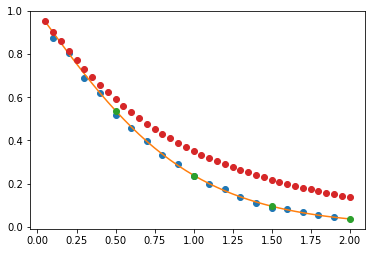

In [447]:
import matplotlib.pyplot as plt
plt.plot(betas,t3sqs, 'o')
plt.plot(betams,t3sqms)
plt.plot(betadt,t3sqdt, 'o')
plt.plot(betacts,t3wqcts, 'o')

plt.show()


In [437]:
import csv
def tsqfromfile(beta):
    data =[]
    with open('/scratch1/hornung/dtvspyworm/ct/results/BETAS-{0:.2f}.dat'.format(beta)) as csvfile:
        readCSV = csv.reader(csvfile, delimiter='\t')
        for row in readCSV:
            data = row
    
    return float(data[4])


betacts = [b*0.05 for b in range(1,41)]
t3wqcts = [tsqfromfile(beta) for beta in betas ]

In [442]:
len(betacts)

40

In [435]:
str(0.2)

TypeError: str() argument 2 must be str, not int

In [450]:
from joblib import Parallel, delayed
import multiprocessing
    
# what are your inputs, and what operation do you want to 
# perform on each input. For example...
inputs = range(10) 
def processInput(i):
return i * i

num_cores = multiprocessing.cpu_count()
    
results = Parallel(n_jobs=num_cores)(delayed(processInput)(i) for i in inputs)


In [451]:
num_cores

4